# Set Up Comparison

In [1]:
import os
import numpy as np
import nibabel as nib
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
import matplotlib.pyplot as plt
import sigpy as sp
import sigpy.plot as pl
import numpy as np
import nibabel as nib
import dipy.reconst.dti as dti
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import os
import nibabel as nib
from dipy.data import fetch_bundles_2_subjects
from dipy.io.image import load_nifti, load_nifti_data
import scipy
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
from skimage.metrics import peak_signal_noise_ratio

In [2]:
# Get list of .nii.gz files in the directory 
path = "Data/"
extensions = '.nii.gz'
filelist = []
bvallist = []
bveclist = []
diffdirlist = []
ii=1

for subdir, dirs, files in os.walk(path):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            if ext in extensions:
                t=str(os.path.splitext(file))
                if t[-12:-9] == 'nii':
                    example_filename = os.path.join(subdir, file)
                    name = example_filename.split('/')
                    name1 = name[1].split('_')

                    if name1[0] == "processedDWI":
                        filelist.append(example_filename)
                        
            if ext == '.bval':
                t=str(os.path.splitext(file))
                example_filename = os.path.join(subdir, file)
                name = example_filename.split('/')
                name1 = name[1].split('_')

                if name1[0] == "processedDWI":
                    bvallist.append(example_filename)
                    
            if ext == '.bvec':
                t=str(os.path.splitext(file))
                example_filename = os.path.join(subdir, file)
                name = example_filename.split('/')
                name1 = name[1].split('_')

                if name1[0] == "processedDWI":
                    bveclist.append(example_filename)
                    
            if ext == '.mat':
                t=str(os.path.splitext(file))
                example_filename = os.path.join(subdir, file)
                name = example_filename.split('/')
                name1 = name[1].split('_')
                
                
                diffdirlist.append(example_filename)

# List of MR Data, bvalues, and bvecs                    
scanlist = list(np.sort(filelist))
bvals = list(np.sort(bvallist))
bvecs = list(np.sort(bveclist))
diffdirs = list(np.sort(diffdirlist))

In [3]:
## Load 1 image file 
from skimage.transform import rescale, resize, downscale_local_mean
import scipy.io
from dipy.io import read_bvals_bvecs

num = 1
data, affine1, img = load_nifti(scanlist[num], return_img=True)
bval, bvec = read_bvals_bvecs(bvals[num], bvecs[num])

optimaldirs = scipy.io.loadmat(diffdirs[num])
sixDirs = optimaldirs['ind_all'] - 1

In [4]:
# Generate Training, Validation, and Testing Data
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.segment.mask import median_otsu
import random

cropx=int(128)
cropy=int(128)
factor = data.shape[0]/cropx
cropz = int(data.shape[2] // factor)

model_in = np.zeros((cropx,cropy,cropz,7,1))
model_out = np.zeros((cropx,cropy,cropz,1,1))

# Sort Diffusion 
b0s = data[:,:,:,bval<10]
meanb0 = np.mean(b0s,3)
dwis = data[:,:,:,bval>10]
bvals_dwi = bval[bval > 10]
bvecs_dwi = bvec[bval>100,:]
dirs = bvec[bval>100,:]

for ii in range(1): #sixDirs.shape[0]
    b0 = b0s[:,:,:,random.randint(0,b0s.shape[-1]-1)]
    data1 = np.concatenate((b0[:,:,:,np.newaxis],dwis[:,:,:,list(sixDirs[ii,:])]),axis = -1)
    shape = np.shape(data1)
    
    # Input Array Make [6 diffusion directions]
    padded_array = np.pad(data1,((0,0),(2,2),(0,0),(0,0)))
    
    F = sp.linop.FFT(padded_array.shape, axes=(0, 1, 2))
    kspc = F(padded_array)
    
    
    x,y,z,dd = kspc.shape   # Get dimensions
    startx = int(x//2-(cropx//2))
    starty = int(y//2-(cropy//2))  
    startz = int(z//2-(cropz//2))  
    
    kspc_crop = kspc[startx:startx+cropx,starty:starty+cropy,startz:startz+cropz,:]
    Fcrop = sp.linop.FFT(kspc_crop.shape, axes=(0,1,2))
    im_crop =abs(Fcrop.H(kspc_crop))

    _, mask = median_otsu(im_crop[:,:,:,0])
    maskdata = im_crop * np.repeat(mask[:,:,:,np.newaxis],im_crop.shape[-1],axis=-1)
    model_in[:,:,:,:,ii] = maskdata
    
    #Output Array Make [calculated FA from 20 Diffusion Directions]
    dirs20 = random.sample(range(bvals_dwi.shape[0]),20)
    bvals_20dirs = np.insert(bvals_dwi[dirs20],0,0,axis = 0)
    bvecs_20dirs = np.insert(bvecs_dwi[dirs20,:],0,[0,0,0],axis = 0)
    gtab = gradient_table(bvals_20dirs, bvecs_20dirs)
    
    data1 = np.concatenate((b0[:,:,:,np.newaxis],dwis[:,:,:,dirs20]),axis = -1)
    shape = np.shape(data1)
    
    padded_array = np.pad(data1,((0,0),(2,2),(0,0),(0,0)))
    
    F = sp.linop.FFT(padded_array.shape, axes=(0, 1, 2))
    kspc = F(padded_array)
    
    
    x,y,z,dd = kspc.shape   # Get dimensions
    startx = int(x//2-(cropx//2))
    starty = int(y//2-(cropy//2))  
    startz = int(z//2-(cropz//2))  
    
    kspc_crop = kspc[startx:startx+cropx,starty:starty+cropy,startz:startz+cropz,:]
    Fcrop = sp.linop.FFT(kspc_crop.shape, axes=(0,1,2))
    im_crop =abs(Fcrop.H(kspc_crop))

    _, mask = median_otsu(im_crop[:,:,:,0])   

    maskdata = im_crop * np.repeat(mask[:,:,:,np.newaxis],im_crop.shape[-1],axis=-1)

    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(maskdata)
    
    FA = fractional_anisotropy(tenfit.evals)
    FA[np.isnan(FA)] = 0
    fa_img = nib.Nifti1Image(FA.astype(np.float32), np.eye(4))
    
    
    model_out[:,:,:,0,ii] = FA
    
    print(ii,end=' ')

0 

In [5]:
np.squeeze(model_in).shape

(128, 128, 84, 7)

In [6]:
# Save training, test, and validaiton data
from numpy import save
save('ComparisonDataset/model_in.npy',(model_in))
save('ComparisonDataset/model_out.npy',model_out)

In [7]:
# NIFTI for Diff UNET
nifti_img = nib.Nifti1Image(np.squeeze(model_in), img.affine, img.header)
nib.save(nifti_img, 'ComparisonDataset/model_in.nii.gz')

In [8]:
# Format file for network to use
test_in = model_in[:,:,:,:,:]
test_in1 = np.transpose(test_in,(3,0,1,2,4))
test_in1 = np.reshape(test_in1,(test_in.shape[3],test_in.shape[0],test_in.shape[1],test_in.shape[2]*test_in.shape[4]))
test_in1 = np.transpose(test_in1,(0,-1,1,2))

test_out = model_out[:,:,:,:,:]
test_out1 = np.transpose(test_out,(3,0,1,2,4))
test_out1 = np.reshape(test_out1,(test_out.shape[3],test_out.shape[0],test_out.shape[1],test_out.shape[2]*test_out.shape[4]))
test_out1 = np.transpose(test_out1,(0,-1,1,2))

save('ComparisonDataset/test/data_in.npy',test_in1)
save('ComparisonDataset/test/data_out.npy',test_out1)

print(test_in1.shape,test_out1.shape)

(7, 84, 128, 128) (1, 84, 128, 128)


In [9]:
# Get traditional 6dirs FA
dirs6 = sixDirs[ii,:]
bvals_6dirs = np.insert(bvals_dwi[dirs6],0,0,axis = 0)
bvecs_6dirs = np.insert(bvecs_dwi[dirs6,:],0,[0,0,0],axis = 0)
gtab = gradient_table(bvals_6dirs, bvecs_6dirs)

tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(np.squeeze(model_in))


FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0
fa_img = nib.Nifti1Image(FA.astype(np.float32), np.eye(4))

save('ComparisonDataset/model_FA6dirs.npy',(FA))


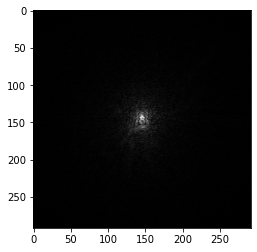

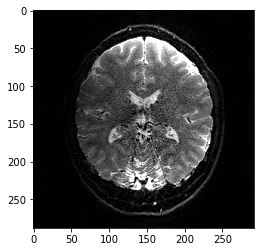

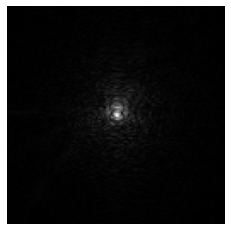

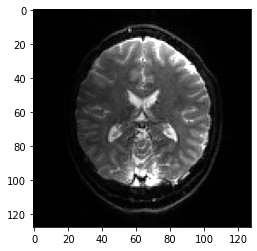

In [46]:
plt.imshow(np.rot90(abs(kspc[:,:,90,0])),cmap = 'gray')
plt.show()

plt.imshow(np.rot90(data1[:,:,90,0]),cmap = 'gray',vmin = 0, vmax = 4000)
plt.show()

plt.imshow(np.rot90(abs(kspc_crop[:,:,45,0])),cmap = 'gray',vmin = 0)
plt.axis('off')
plt.show()

plt.imshow(np.rot90(abs(im_crop[:,:,40,0])),cmap = 'gray',vmin = 0, vmax = 15000)

plt.show()

In [47]:
b0s.shape

(292, 288, 192, 16)

# Gold Standard

In [106]:
gold_data = np.load('ComparisonDataset/gt_processedDWI_session1_subset02out.npy')
gold_in = np.load('ComparisonDataset/gt_processedDWI_session1_subset02in.npy')

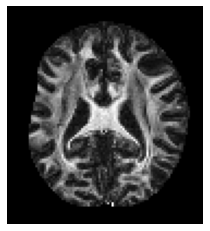

In [114]:
plt.imshow(np.rot90(gold_data[20:110,15:115,45]),vmin = 0,vmax = 1,cmap = 'gray')
plt.axis('off')
plt.show()

# Generate baseline extremes

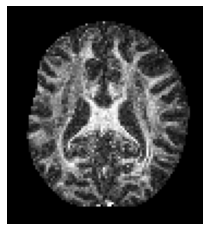

<ipython-input-192-b50638c0baab>:6: RuntimeWarning: divide by zero encountered in true_divide
  test = abs(gold_data[:,:,45] - np.squeeze(model_out[:,:,45,0]))/gold_data[:,:,45] *100
<ipython-input-192-b50638c0baab>:6: RuntimeWarning: invalid value encountered in true_divide
  test = abs(gold_data[:,:,45] - np.squeeze(model_out[:,:,45,0]))/gold_data[:,:,45] *100


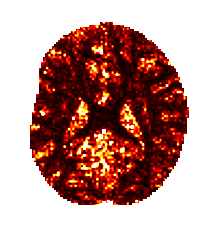

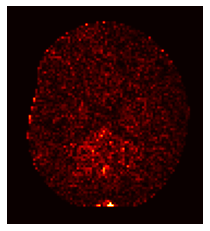

In [192]:
# 20 dirs ground truth! 
plt.imshow(np.rot90(model_out[20:110,15:115,45,0]),vmin = 0,vmax = 1,cmap = 'gray')
plt.axis('off')
plt.show()

test = abs(gold_data[:,:,45] - np.squeeze(model_out[:,:,45,0]))/gold_data[:,:,45] *100
plt.imshow(np.rot90(test[20:110,15:115]),vmin = 0, vmax = 200,cmap = 'hot')
plt.axis('off')
plt.show()

test = abs(gold_data[:,:,45] - np.squeeze(model_out[:,:,45,0]))
plt.imshow(np.rot90(test[20:110,15:115]),vmin = 0, vmax = 1,cmap = 'hot')
plt.axis('off')
plt.show()

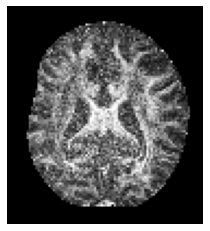

<ipython-input-193-2224c623c5b2>:6: RuntimeWarning: divide by zero encountered in true_divide
  test = abs(gold_data[:,:,45] - np.squeeze(FA[:,:,45]))/gold_data[:,:,45] *100
<ipython-input-193-2224c623c5b2>:6: RuntimeWarning: invalid value encountered in true_divide
  test = abs(gold_data[:,:,45] - np.squeeze(FA[:,:,45]))/gold_data[:,:,45] *100


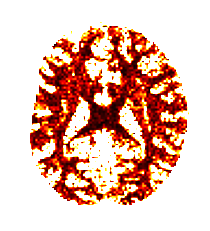

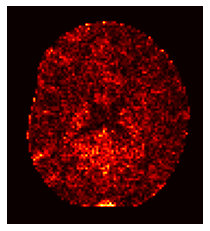

In [193]:
# 6 dirs usual 
plt.imshow(np.rot90(FA[20:110,15:115,45]),vmin = 0,vmax = 1,cmap = 'gray')
plt.axis('off')
plt.show()

test = abs(gold_data[:,:,45] - np.squeeze(FA[:,:,45]))/gold_data[:,:,45] *100
plt.imshow(np.rot90(test[20:110,15:115]),vmin = 0, vmax = 100,cmap = 'hot')
plt.axis('off')
plt.show()

test = abs(gold_data[:,:,45] - np.squeeze(FA[:,:,45]))
plt.imshow(np.rot90(test[20:110,15:115]),vmin = 0, vmax = 1,cmap = 'hot')
plt.axis('off')
plt.show()

# Load Diffnet  result and display

In [160]:
diffnet = np.load('ComparisonDataset/dFA.npy')
diffnet = diffnet/np.nanmax(diffnet)

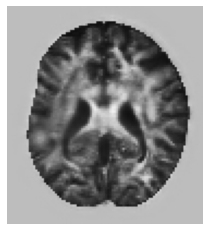

<ipython-input-196-c45d2165c507>:5: RuntimeWarning: divide by zero encountered in true_divide
  test = abs(gold_data[:,:,45] - diffnet[:,:,45,0])/gold_data[:,:,45] *100


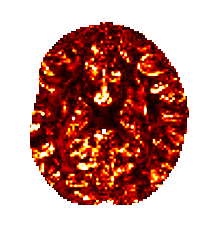

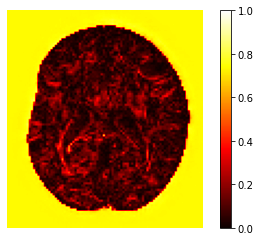

In [196]:
plt.imshow(np.rot90(np.nan_to_num(diffnet[20:110,15:115,45,0])),vmin = 0,vmax = 1,cmap = 'gray')
plt.axis('off')
plt.show()

test = abs(gold_data[:,:,45] - diffnet[:,:,45,0])/gold_data[:,:,45] *100
plt.imshow(np.rot90(test[20:110,15:115]),vmin = 0, vmax = 200,cmap = 'hot')
plt.axis('off')
plt.show()

test = abs(gold_data[:,:,45] - diffnet[:,:,45,0])
plt.imshow(np.rot90(test[20:110,15:115]),vmin = 0, vmax = 1,cmap = 'hot')
plt.axis('off')
plt.colorbar()
plt.show()


In [156]:
np.nanmax(diffnet[:,:,45,0]/np.nanmax(diffnet))

0.9417023

In [151]:
np.nanmax(gold_data)

0.9999995632495366